Firstly there are a few helper methods supplied to get data from the current fantasy football website. We will use this in the future during inference with our model created with TensorFlow.

In [1]:
import json
import requests


def get_players():
    url = 'https://fantasy.premierleague.com/drf/elements/'
    return requests.get(url).json()


def get_teams():
    url = 'https://fantasy.premierleague.com/drf/teams/'
    return requests.get(url).json()


def get_goalkeepers():
    players = get_players()
    goalkeepers = []
    for player in players:
        if player['element_type'] is 1:
            goalkeepers.append(player)
    return goalkeepers


def get_defenders():
    players = get_players()
    defenders = []
    for player in players:
        if player['element_type'] is 2:
            defenders.append(player)
    return defenders


def get_midfielders():
    players = get_players()
    midfielders = []
    for player in players:
        if player['element_type'] is 3:
            midfielders.append(player)
    return midfielders


def get_forwards():
    players = get_players()
    forwards = []
    for player in players:
        if player['element_type'] is 4:
            forwards.append(player)
    return forwards

In the next box, we can load up some data from a previous season (2014/2015) and use it for supervised learning. Note that by using this data with the notion of using the created model on today's and the futures data we implicitly assume that similarities in a single previous season could reoccur in a successive one. This of course could be complete bollocks. 

Data obtained from:
https://www.reddit.com/r/FantasyPL/comments/38197f/i_have_complete_fantasy_premier_league_201415/

Rough translation from current api keys (from json) from official website to the old data found at the above Reddit link. Not all of it is clear in terms of the translation but there is some data we can use!
```
Mins           = minutes
Goals          = goals_scored
Assists        = assists
Clean_Sheets   = clean_sheets
Goals_Conceded = goals_conceded
Yellow_Cards   = yellow_cards
Saves          = saves 
Bonus          = bonus
PPI            = ?
BPS            = bps
Net_Transfers  = ? transfers_in? transfers_out? transfers_in_event? 
Value          = ? value_season? 
Points         = ? event_points? 
```

In [2]:
import csv
    
    
def get_concatenated_data():
    """
    Concatenate the data found at the supplied link above
    to something a little more convenient.
    """
    def get_file_data(file_path):
        rows = []
        with open(file_path, encoding='ISO-8859-1') as file:
            reader = csv.reader(file, delimiter=',')
            for row in reader:
                rows.append(row)
        return rows
    
    details = get_file_data('Player_Details.csv')
    data = get_file_data('Player_Data.csv')
    concatenated_rows = []
    
    for i, data_row in enumerate(data):
        if i != 0:
            player_id = data_row[0]
            for j, player_row in enumerate(details):
                if j != 0:
                    if player_row[0] == player_id:
                        temp_row = []
                        temp_row.extend(player_row)
                        temp_row.extend(data_row)
                        concatenated_rows.append(temp_row)
    return concatenated_rows, details[0] + data[0]
           
    
all_old_data, help_header = get_concatenated_data()

for i, value in enumerate(help_header):
    print(i, value)

0 ID
1 Name
2 Team
3 Position
4 Availability
5 Selection
6 EA_Index
7 Price
8 ID
9 Week
10 Opponent
11 Venue
12 Mins
13 Goals
14 Assists
15 Clean_Sheets
16 Goals_Conceded
17 Yellow_Cards
18 Red_Cards
19 Saves
20 Bonus
21 PPI
22 BPS
23 Net_Transfers
24 Value
25 Points


In [3]:
import numpy as np
from sklearn.preprocessing import normalize

desired_indices = [6, 7, 12, 13, 14, 16, 17, 18, 20, 21, 22, 24, 25]
desired_player_position = "Midfielder"
other_desired_player_position = "Forward"
normalise_data = False


def get_desired_data(data, desired_indices, player_position, other_player_position):
    """
    Using the above features create supervised data for
    TensorFlow neural networks.
    """
    previous_id = int(data[0][0])
    previous_week = int(data[0][9])
    previous_value = float(data[0][25])
    total_data_size = len(data)
    approx_amount_zeros = total_data_size

    labels = []
    features = []

    index = 1
    while index < total_data_size:
        current_id = int(data[index][0])
        current_week = int(data[index][9])
        position = data[index][3]

        correct_position = position == player_position or position == other_player_position
        correct_id = previous_id == current_id
        corrent_week = (current_week - 1) == previous_week

        if (correct_position and correct_id and corrent_week):
            current_value = float(data[index][25])    
            if current_value != 0 or index < approx_amount_zeros:
                features.append([float(data[index - 1][i]) for i in desired_indices])
                labels.append(current_value)
                previous_value = current_value
        index += 1

        previous_id = current_id
        previous_week = current_week
    return np.array(features), np.array(labels).reshape((-1, 1))

features, labels = get_desired_data(all_old_data,
                                    desired_indices,
                                    desired_player_position,
                                    other_desired_player_position)
if normalise_data:
    features = normalize(features)
    labels = normalize(labels)

train_split = int(0.8 * len(features))
train_x = features[0:train_split]
train_y = labels[0:train_split]
valid_x = features[:-train_split]
valid_y = labels[:-train_split]

print(len(train_x), "available training examples.")
print(len(valid_x), "available validation examples.")

11033 available training examples.
2759 available validation examples.


In [4]:
import tflearn
import tensorflow as tf

tf.reset_default_graph()

net = tflearn.input_data(shape=[None, train_x.shape[1]])
net = tflearn.fully_connected(net, 120, activation='relu',
                              regularizer='L2', weight_decay=0.001)
net = tflearn.dropout(net, 0.8)
net = tflearn.fully_connected(net, 80, activation='relu',
                              regularizer='L2', weight_decay=0.001)
net = tflearn.dropout(net, 0.8)
net = tflearn.fully_connected(net, 1, activation='linear')

net = tflearn.regression(net, optimizer='adam', loss='mean_square')

model = tflearn.DNN(net, tensorboard_verbose=0)
model.fit(train_x, train_y, n_epoch=1000, validation_set=(valid_x, valid_y), 
          shuffle=True, show_metric=True, run_id="dense_model")

Training Step: 172999  | total loss: 4.03459 | time: 0.751s
| Adam | epoch: 1000 | loss: 4.03459 - binary_acc: 0.2909 -- iter: 11008/11033
Training Step: 173000  | total loss: 3.77330 | time: 1.760s
| Adam | epoch: 1000 | loss: 3.77330 - binary_acc: 0.2993 | val_loss: 3.84317 - val_acc: 0.4386 -- iter: 11033/11033
--


2759 total predictions
2069 predictions with under 1 distance

1.0561 is the mean prediction
5.29215 is the max prediction
-0.0456786 is the min prediction

0.908034029107 is the mean difference between prediction and target value
21.0683026314 is the max difference between prediction and target value
0.00282788276672 is the min difference between prediction and target value

0.511841469309 is the mean value to be predicted when prediction is very close
5.0 is the max value to be predicted when prediction is very close
0.0 is the min value to be predicted when prediction is very close


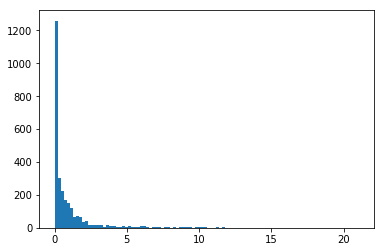

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline

predictions = model.predict(valid_x)
dist = 1
differences = []
under_one_difference = []
for i, prediction in enumerate(predictions):
    diff = abs(prediction - valid_y[i])
    differences.append(diff)
    if (diff <= dist):
        under_one_difference.append(valid_y[i])
        
differences = np.array(differences).reshape(-1).tolist()
under_one_difference = np.array(under_one_difference).reshape(-1).tolist()

print(len(differences), "total predictions")
print(len(under_one_difference), "predictions with under", dist, "distance\n")
print(np.mean(predictions), "is the mean prediction")
print(np.max(predictions), "is the max prediction")
print(np.min(predictions), "is the min prediction\n")
print(np.mean(differences), "is the mean difference between prediction and target value")
print(np.max(differences), "is the max difference between prediction and target value")
print(np.min(differences), "is the min difference between prediction and target value\n")
print(np.mean(under_one_difference), "is the mean value to be predicted when prediction is very close")
print(np.max(under_one_difference), "is the max value to be predicted when prediction is very close")
print(np.min(under_one_difference), "is the min value to be predicted when prediction is very close")

_ = plt.hist(differences, bins=100)

It can some times be hard to beat choosing values completely randomly, so I did that to show the neural network is learning something. 

It is relatively clear here that the random selection histogram shows vast amounts of difference between the prediction and actual when predicting random values in the range of the labels min and max.

2759 total predictions
204 predictions with under 1 distance

1.0561 is the mean prediction
5.29215 is the max prediction
-0.0456786 is the min prediction

10.4668050463 is the mean difference between prediction and target value
23.9864054965 is the max difference between prediction and target value
0.00134899484294 is the min difference between prediction and target value

1.41176470588 is the mean value to be predicted when prediction is very close
16.0 is the max value to be predicted when prediction is very close
0.0 is the min value to be predicted when prediction is very close


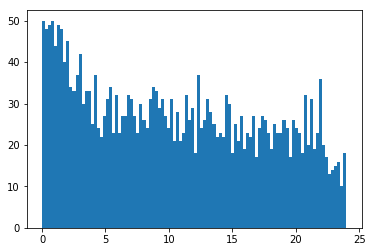

In [7]:
random_predictions = np.random.uniform(np.min(labels), np.max(labels), valid_y.shape)
dist = 1
differences = []
under_one_difference = []
for i, prediction in enumerate(random_predictions):
    diff = abs(prediction - valid_y[i])
    differences.append(diff)
    if (diff <= dist):
        under_one_difference.append(valid_y[i])
        
differences = np.array(differences).reshape(-1).tolist()
under_one_difference = np.array(under_one_difference).reshape(-1).tolist()

print(len(differences), "total predictions")
print(len(under_one_difference), "predictions with under", dist, "distance\n")
print(np.mean(predictions), "is the mean prediction")
print(np.max(predictions), "is the max prediction")
print(np.min(predictions), "is the min prediction\n")
print(np.mean(differences), "is the mean difference between prediction and target value")
print(np.max(differences), "is the max difference between prediction and target value")
print(np.min(differences), "is the min difference between prediction and target value\n")
print(np.mean(under_one_difference), "is the mean value to be predicted when prediction is very close")
print(np.max(under_one_difference), "is the max value to be predicted when prediction is very close")
print(np.min(under_one_difference), "is the min value to be predicted when prediction is very close")
_ = plt.hist(differences, bins=100)